# HLAthena
### A Python package for HLA class I peptide analysis, binding prediction, and model training

## Installation

To install hlathena run: 

    git clone https://github.com/ssarkizova/hlathenav2
    cd hlathenav2
    pip install .

## Usage

#### Importing the package

In [1]:
import hlathena as ht 

Next, we'll import some example data

In [3]:
import pandas as pd
sample_pep_file = "A0101_filtered.txt"
df = pd.read_table(sample_pep_file)
peptides = list(df['seq'])

### Peptide analysis

First, we'll plot the length distribution of the peptide set.

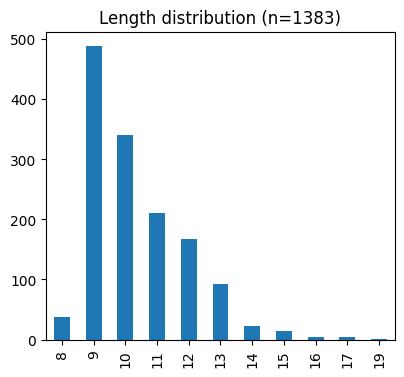

In [3]:
ht.plot_length(peptides)

Next, we'll visualize the amino acid motifs of this peptide set

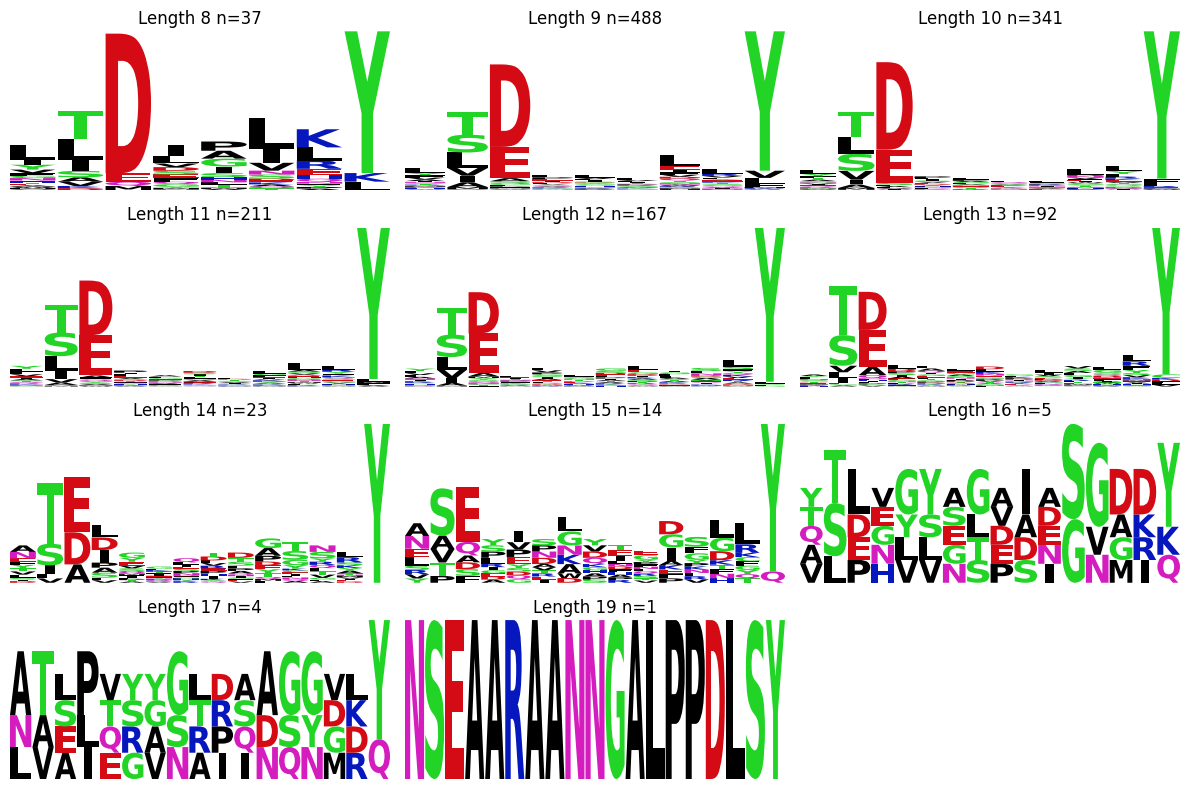

In [4]:
ht.plot_logo(peptides)

Let's examine the 9mer's motif more closely

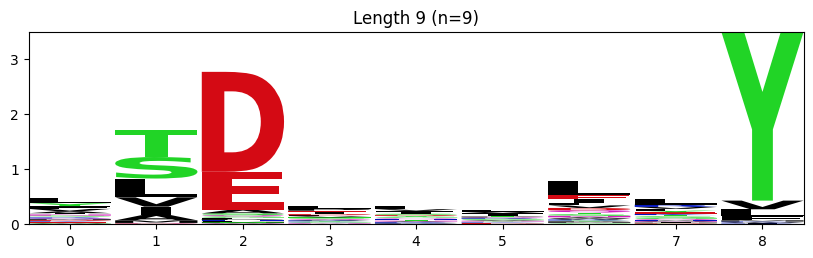

In [5]:
ht.plot_logo(peptides, 9)

Next, we want to cluster these peptides with a UMAP. First, we'll neeed to do some dimensionality reduction using the peptide projection module.

We will specify that we want to use Kidera Factors for the amino acid encoding by providing a file path. Additional files with amino acid encodings can be included (they must be tab-delimited txt files with one row per amino acid symbol and 1+ columns). 

We will also save this encoding in case we want to re-use it later.

In [6]:
feature_matrix = ht.PCA_encode(peptides, 'A0101', 9, aa_featurefiles=['kideraFactors.txt'], save_PCA_path='pca_encoding.npz')

Now we can make a simple UMAP plot:

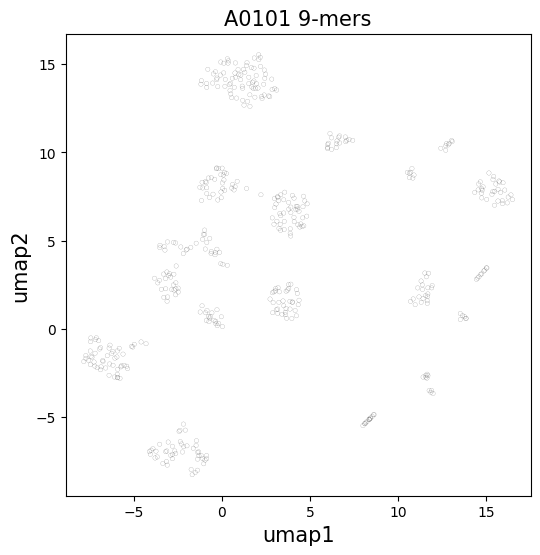

In [7]:
ht.plot_umap(feature_matrix, title='A0101 9-mers')

### Annotate peptide set

In [8]:
pep_df = pd.DataFrame(peptides, columns=['seq'])
annotated_peptides = ht.get_reference_gene_ids(pep_df, add_context=True)
annotated_peptides.head()

,seq,Hugo_Symbol,ctex_up,ctex_dn
0,YSDVAKGILQY,SPATA20,HVPHFEKMLYDQAQLAVAYSQAFQLSGDEF,VARSLSHRSGGFYSAEDADSPPERGQRPK-
1,HIDFGGTSVWY,KDM7A,ENYWPDDSVFPKPFVQKYCLMGVQDSYTDF,HVLWGEKIFYLIKPTDENLARYESWSSSV-
2,YLETVAAYY,IL32,PKVLSDDMKKLKARMVMSSLAELEDDFKEG,EEQHPELTPLLEKERDGLRCRGNRSPVPD-
3,LSELFMSSFQSY,IL32,GVLAWVKEKVVALVHAVQALWKQFQSFCCS,GAPRGDKEELTPQKCSEPQSSK--------
4,HSEFLTVPAGSY,HIVEP2,LSHSSSFSMSFEREETSKLSALPKQDEFGK,SLSVPGHHHQKEMRRCSSEQMPCPHPAEV-


Next, we will annotate with TCGA reference data. In order to determine which options are available and/or the TCGA cancer type abbreviation, we call the ```list_expression_references()``` function. In this case, we will annotate with reference breast cancer expression data. 

In [9]:
ht.list_expression_references().head() # TODO: add column in helper file to specify tcga

,Study Name
Study Abbreviation,
LAML,Acute Myeloid Leukemia
ACC,Adrenocortical carcinoma
BLCA,Bladder Urothelial Carcinoma
LGG,Brain Lower Grade Glioma
BRCA,Breast invasive carcinoma


 We find the relevant TCGA abbreviation and call ```add_tcga_expression```.

In [10]:
annotated_peptides = ht.add_tcga_expression(annotated_peptides, 'BRCA')

### Example GSEA Analysis

To do gene set enrichment analysis (GSEA) on this peptide set, we first create a gene/avg. sample expression matrix. In this case we will use BRCA_TPM as our sample values.



In [10]:
import gseapy as gp

In [11]:
IFN_response_genes = pd.read_table('HALLMARK_INTERFERON_GAMMA_RESPONSE.v2023.1.Hs.txt',header=None)
IFN_response_genes = list(IFN_response_genes[0])

In [12]:
IFNy_samples = pd.read_excel('IFNy_sample_data/41587_2019_322_MOESM10_ESM - NBT 2019 Supp6.xlsx', usecols=['Clinical ID','Type','Length','Peptide'])
GBM = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187']
GBM_IFN = IFNy_samples.loc[IFNy_samples['Clinical ID']=='H4198-BT187_IFN']



In [13]:
GBM = ht.get_reference_gene_ids(GBM, pep_col='Peptide', add_context=False)
GBM_IFN = ht.get_reference_gene_ids(GBM_IFN, pep_col='Peptide', add_context=False)

We count the number of peptides from IFN response genes according to our gene annotations:

In [14]:
GSEA_GBM = gp.enrichr(gene_list=list(GBM['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_GSEA_results')
GSEA_GBM_IFN = gp.enrichr(gene_list=list(GBM_IFN['Hugo_Symbol']), gene_sets=['MSigDB_Hallmark_2020'], outdir='GBM_IFN_GSEA_results')

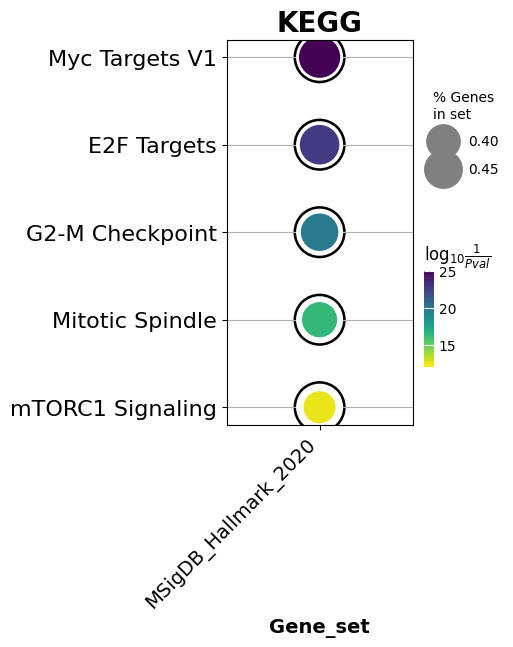

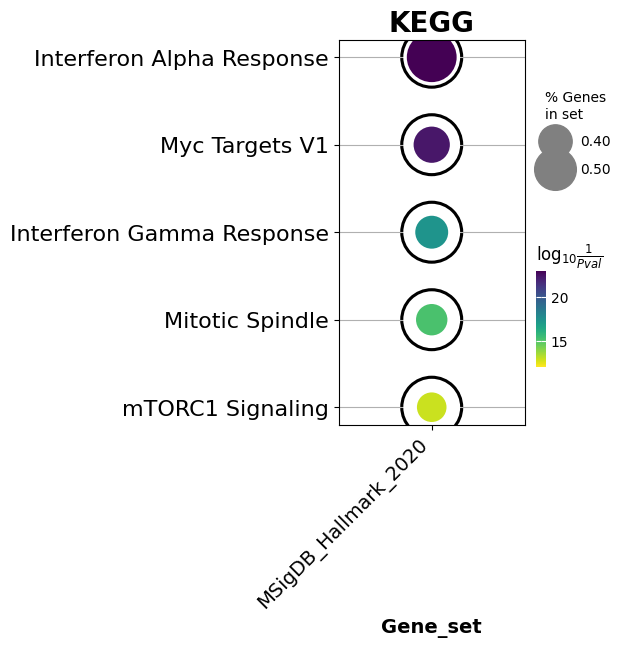

In [15]:
from gseapy import barplot, dotplot
import matplotlib.pyplot as plt

ax1 = dotplot(GSEA_GBM.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )
ax2 = dotplot(GSEA_GBM_IFN.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

# plt.show()

### Clustering and comparing the GBM peptides

In [14]:
GBM['label'] = 'GBM'
GBM_IFN['label'] = 'GBM_with_IFN'
full_GBM_df = pd.concat([GBM,GBM_IFN])
full_GBM_df.head()

,seq,Hugo_Symbol,label
0,LAAGHLVQL,CYP51A1,GBM
1,TMVGKTFTY,CYP51A1,GBM
2,HTSSTTSAW,CYP51A1,GBM
3,YTIPPGHQV,CYP51A1,GBM
4,GSDVVDWLY,DVL2,GBM


To make a UMAP comparison, we'll need to select a particular length. We can once again use the ```plot_length``` function to find the length distribution of the combined dataset.

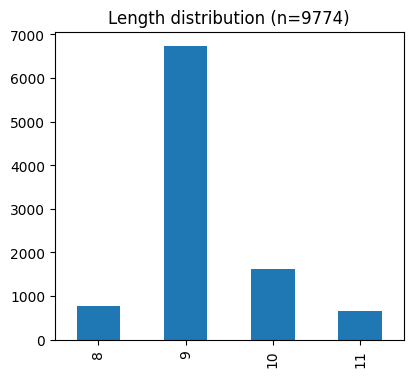

In [16]:
ht.plot_length(full_GBM_df['seq'])

In [17]:
GBM_feature_matrix = ht.PCA_encode(full_GBM_df['seq'], 'A0101', 9, aa_featurefiles=['kideraFactors.txt'])

/home/clf176/Desktop/hlathena_package/package/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/clf176/Desktop/hlathena_package/package/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/home/clf176/Desktop/hlathena_package/package/lib/python3.7/site-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. 

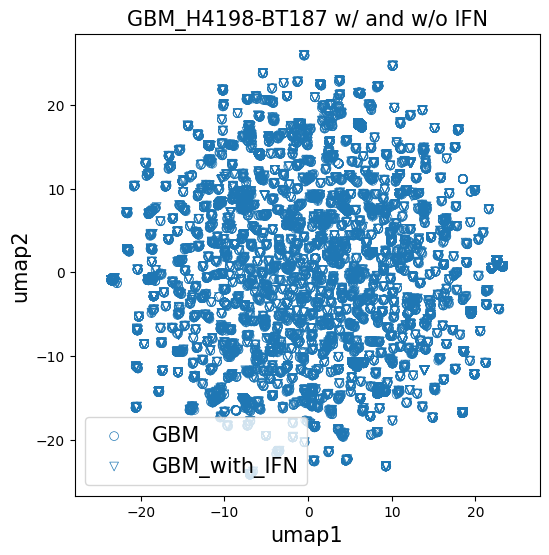

In [20]:
# full_GBM_df = full_GBM_df.set_index('seq')

ht.plot_clustered_umap(GBM_feature_matrix, \
                        full_GBM_df, \
                        eps = 10, \
                        min_samples = 7, \
                        title="GBM_H4198-BT187 w/ and w/o IFN")

### Peptide binding prediction

In [ ]:
model_path = '../models/NN-time2022-12-16_10-fold0.pt'

ninemers = [pep for pep in peptides if len(pep)==9] # create list of ninemers 
ht.predict(model_path, ninemers)